
# Bug hunting with Lauge.
_File Description_

In this file, we will hunt systematically for bugs in the entire code base.
When making changes to the code, please tun the relevant sections in this file (preferably all of them) to make 
sure that nothing breaks, and that it yields the results that you expect.


In [1]:
# imports
import os
import sys
import time
import json

from tqdm import tqdm
from PIL import Image
import torch as th
import matplotlib.pyplot as plt

from model_camera_calibration import CameraCalibrationModel
from model_camera_extrinsics import CameraExtrinsics
from dataset import ImagePoseDataset
from data_module import ImagePoseDataModule
from Lie_barf import Lie

## Testing the dataset

In [2]:
# list all methods of imageposedataset
methods = [method for method in dir(ImagePoseDataset) if callable(getattr(ImagePoseDataset, method)) and not method.startswith("__")]
print("\n".join(methods))


_apply_noise
_get_cam_origs_and_directions
_get_directions_meshgrid
_load_camera_info
_load_images
_meshgrid_to_world
_screw_up_original_camera_poses_for_testing_validation_transform_in_CameraCalibrationModel
_transform_camera_to_world
gaussian_blur
subset_dataset


### `_load_camera_info()`

In [3]:
# test only _load_camera_info

img_names = "r_0", "r_1"

camera_data_modified = json.loads(open("../data/lego/transforms_train_modified.json").read())
_, cam_to_world_test = ImagePoseDataset._load_camera_info("../data/lego/transforms_train_modified.json", 200)
cam_to_world_true = {data["file_path"].split("/")[-1]: th.tensor(data["transform_matrix"]) for data in camera_data_modified["frames"]}

for img_name in img_names:
    assert th.allclose(cam_to_world_test[img_name][:3,:3], cam_to_world_true[img_name][:3,:3]), f"Rotation matrix not equal for {img_name}"
    assert th.allclose(cam_to_world_test[img_name][:3,3]/cam_to_world_test[img_name][3,3],
                       cam_to_world_true[img_name][:3,3]/cam_to_world_true[img_name][3,3]), f"Translation matrix not equal for {img_name}"
print("Camera info test passed")


Camera info test passed


### `_get_directions_meshgrid()`

In [85]:
H, W = 10, 2

y, x = th.meshgrid(
    -th.linspace(-(H-1)/2, (H-1)/2, H) / 4,
    th.linspace(-(W-1)/2, (W-1)/2, W) / 4,
    indexing="ij"
)
directions = th.stack((x, y, -th.ones_like(x)), dim=-1)
# directions /= th.norm(directions, p=2, dim=-1, keepdim=True)
print(directions.shape)
print(directions.view(-1,3))

torch.Size([10, 2, 3])
tensor([[-0.1250,  1.1250, -1.0000],
        [ 0.1250,  1.1250, -1.0000],
        [-0.1250,  0.8750, -1.0000],
        [ 0.1250,  0.8750, -1.0000],
        [-0.1250,  0.6250, -1.0000],
        [ 0.1250,  0.6250, -1.0000],
        [-0.1250,  0.3750, -1.0000],
        [ 0.1250,  0.3750, -1.0000],
        [-0.1250,  0.1250, -1.0000],
        [ 0.1250,  0.1250, -1.0000],
        [-0.1250, -0.1250, -1.0000],
        [ 0.1250, -0.1250, -1.0000],
        [-0.1250, -0.3750, -1.0000],
        [ 0.1250, -0.3750, -1.0000],
        [-0.1250, -0.6250, -1.0000],
        [ 0.1250, -0.6250, -1.0000],
        [-0.1250, -0.8750, -1.0000],
        [ 0.1250, -0.8750, -1.0000],
        [-0.1250, -1.1250, -1.0000],
        [ 0.1250, -1.1250, -1.0000]])


In [5]:
meshgrid = ImagePoseDataset._get_directions_meshgrid(image_width=2, image_height=4, focal_length=4)
target_meshgrid_raw = th.tensor([
                                [-1/8,  3/8, -1],
                                [ 1/8,  3/8, -1],
                                [-1/8,  1/8, -1],
                                [ 1/8,  1/8, -1],
                                [-1/8, -1/8, -1],
                                [ 1/8, -1/8, -1],
                                [-1/8, -3/8, -1],
                                [ 1/8, -3/8, -1],
                            ])
target_meshgrid_normalized = target_meshgrid_raw/th.linalg.vector_norm(target_meshgrid_raw, dim=1, keepdim=True)

assert th.allclose(meshgrid, target_meshgrid_normalized), "Meshgrid not equal"
print("Meshgrid test passed")

Meshgrid test passed


### `_get_cam_origs_and_directions()`

In [6]:
R = CameraExtrinsics.so3_to_SO3(th.tensor([0.9, 0.2, 0.3]))
t = th.tensor([2.3, 0.2, 1.3])
cam_to_world = th.eye(4)
cam_to_world[:3,:3] = R
cam_to_world[:3,3] = t

d = R @ th.tensor([0,0,-1.])
o = t

o_hat, d_hat = ImagePoseDataset._get_cam_origs_and_directions(cam_to_world.unsqueeze(0))

assert th.allclose(o, o_hat), "Camera origin not equal"
assert th.allclose(d, d_hat), "Camera direction not equal"
print("Camera origin and direction test passed")

Camera origin and direction test passed


### `_meshgrid_to_world()`

In [7]:
meshgrid = th.tensor([[0,0.,-1],
                      [0,0.,-1]])
world_origs, world_dir = ImagePoseDataset._meshgrid_to_world(meshgrid, cam_to_world.unsqueeze(0))
assert th.allclose(world_dir, d.repeat(2,1)), "Directions to world not equal"
assert th.allclose(world_origs, o.repeat(2,1)), "Origins to world not equal"
print("Meshgrid to world test passed")

Meshgrid to world test passed


### `_apply_noise()`

In [8]:
dataset = ImagePoseDataset(15, 10, "../data/lego/train/", "../data/lego/transforms_train.json", 1, th.tensor([0,0,0.]), 0.15, 0.15, 42)

In [9]:
camera_origs, camera_dirs = dataset.camera_origins, dataset.camera_directions
camera_origs_noisy, camera_dirs_noisy = dataset.camera_origins_noisy, dataset.camera_directions_noisy

ray_origs, ray_dirs = dataset.ray_origins, dataset.ray_directions
ray_origs_noisy, ray_dirs_noisy = dataset.ray_origins_noisy, dataset.ray_directions_noisy



In [10]:
assert th.allclose(camera_origs.unsqueeze(1).repeat(1,ray_origs.shape[1],1),ray_origs), "Camera origins not equal to ray origins"

ray_origs_errors = ((ray_origs - ray_origs_noisy)**2).sum(dim=-1).mean()**0.5
camera_origs_errors = ((camera_origs - camera_origs_noisy)**2).sum(dim=-1).mean()**0.5

ray_dirs_cossim = (ray_dirs*ray_dirs_noisy).sum(dim=-1)/th.linalg.vector_norm(ray_dirs, dim=-1)/th.linalg.vector_norm(ray_dirs_noisy, dim=-1)
ray_dirs_angle = (th.acos(ray_dirs_cossim)**2).mean()**0.5
camera_dirs_cossim = (camera_dirs*camera_dirs_noisy).sum(dim=-1)/th.linalg.vector_norm(camera_dirs, dim=-1)/th.linalg.vector_norm(camera_dirs_noisy, dim=-1)
camera_dirs_angle = (th.acos(camera_dirs_cossim)**2).mean()**0.5

print(f"Ray origins error: {ray_origs_errors:.4f}")
print(f"Camera origins error: {camera_origs_errors:.4f}")

print(f"Ray directions angle: {ray_dirs_angle*180/th.pi:.4f}")
print(f"Camera directions angle: {camera_dirs_angle*180/th.pi:.4f}")


Ray origins error: 0.2594
Camera origins error: 0.2594
Ray directions angle: 11.7617
Camera directions angle: 11.7020


### `subset_dataset()`

In [82]:
dataset = ImagePoseDataset(200,
                           100,
                           "../data/lego/train/",
                           "../data/lego/transforms_train.json",
                           1, th.tensor([0,0,0.]),
                           0.15, 0.15, 42,
                           gaussian_blur_sigmas=[20, 5, 0.])

In [83]:
image_names1 = [f"r_{i}" for i in [1,5,4,23,29,78,3,55,12,13,15]]
image_names2 = [image_names1[i] for i in [0,7,10,2]]

dataset1 = dataset.subset_dataset(image_names1)
dataset2 = dataset1.subset_dataset(image_names2)

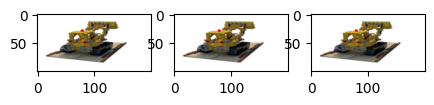

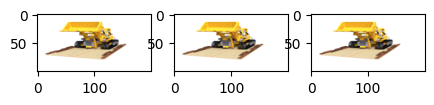

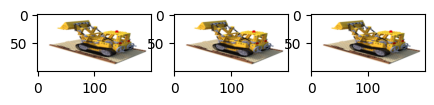

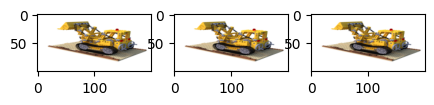

Image name to index test passed
Index to index test passed
subset_dataset test passed


In [87]:
# test the image name to index
for i, img_name in enumerate(image_names2):
    fig = plt.figure(figsize=(5, 2))
    images = []
    for j, d in enumerate([dataset, dataset1, dataset2]):
        fig.add_subplot(1, 3, j+1)
        im = d.images[d.image_name_to_index[img_name], :, :, -1]
        plt.imshow(im)
        images.append(im)

    assert th.allclose(images[0], images[1]), f"Image {img_name} not equal for dataset1"
    assert th.allclose(images[0], images[2]), f"Image {img_name} not equal for dataset2"
    plt.show()

print("Image name to index test passed")

# test index to index
for name in image_names2:
    # get the index in datasets
    idx = dataset.image_name_to_index[name]
    idx1 = dataset1.index_to_index[dataset1.image_name_to_index[name]]
    idx2 = dataset2.index_to_index[dataset2.image_name_to_index[name]]

    assert idx == idx1, f"Index {idx} not equal to index1 {idx1} for image {name}"
    assert idx == idx2, f"Index {idx} not equal to index2 {idx2} for image {name}"

print("Index to index test passed")

print("subset_dataset test passed")



## Camera Extrinsics

In [80]:
lie = Lie()

params = th.randn(1000, 3, requires_grad=True)*th.rand(1000,1)*2

R_barf = lie.so3_to_SO3(params)
R_ours = CameraExtrinsics.so3_to_SO3(params)

barf_error = (th.matmul(R_barf.permute(0,2,1), R_barf) - th.eye(3).unsqueeze(0)).abs().max()
ours_error = (th.matmul(R_ours.permute(0,2,1), R_ours) - th.eye(3).unsqueeze(0)).abs().max()

print(f"BARF: max(R.T @ R) = {barf_error:.3e}")
print(f"ours: max(R.T @ R) = {ours_error:.3e}")

BARF: max(R.T @ R) = 4.107e-05
ours: max(R.T @ R) = 9.060e-06


In [81]:
random_vector = th.randn(1, 3, requires_grad=True)

In [37]:
R_barf - R_ours

tensor([[[ 2.3842e-07,  1.1921e-07, -3.5763e-07],
         [-1.6391e-07, -5.9605e-08,  0.0000e+00],
         [ 5.9605e-07,  4.4703e-08, -1.1921e-07]],

        [[ 1.1921e-07,  2.9802e-08,  0.0000e+00],
         [-2.9802e-08, -1.7881e-07,  0.0000e+00],
         [ 0.0000e+00, -2.9802e-08,  0.0000e+00]],

        [[-8.9407e-07, -4.5896e-06,  3.3528e-06],
         [ 4.8876e-06, -6.5565e-07, -1.1772e-06],
         [-2.9504e-06,  1.9819e-06, -3.5763e-07]]])